In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram

# データのロード

In [2]:
cruise="jare60"
era5 = pd.read_pickle("./{c}_era5_filled.pkl".format(c=cruise))[["mwp", "t2m", "sst", "mwd", "tp", "swh", "u10", "v10"]]
spc = pd.read_pickle("{c}_spc_all.pkl".format(c=cruise))["SPC_flux[mm]"]
shirase = pd.read_pickle("./jare60_all.pkl")

In [4]:
era5_resampled = era5.resample("S").nearest()
# tpは総和なので平均化
era5_resampled['tp'] = era5_resampled['tp'] / 3600

,mwp,t2m,sst,mwd,tp,swh,u10,v10
datetime,,,,,,,,
2018-11-30 07:00:00,9.379121,292.978162,292.091290,215.388038,0.000000e+00,2.639113,4.551841,7.750631
2018-11-30 07:00:01,9.379121,292.978162,292.091290,215.388038,0.000000e+00,2.639113,4.551841,7.750631
2018-11-30 07:00:02,9.379121,292.978162,292.091290,215.388038,0.000000e+00,2.639113,4.551841,7.750631
2018-11-30 07:00:03,9.379121,292.978162,292.091290,215.388038,0.000000e+00,2.639113,4.551841,7.750631
2018-11-30 07:00:04,9.379121,292.978162,292.091290,215.388038,0.000000e+00,2.639113,4.551841,7.750631
...,...,...,...,...,...,...,...,...
2019-03-18 23:59:56,9.516637,294.795984,297.031056,122.921962,1.096460e-07,1.316141,-0.809022,3.587754
2019-03-18 23:59:57,9.516637,294.795984,297.031056,122.921962,1.096460e-07,1.316141,-0.809022,3.587754
2019-03-18 23:59:58,9.516637,294.795984,297.031056,122.921962,1.096460e-07,1.316141,-0.809022,3.587754


In [5]:
shirase_spc = shirase.merge(spc, left_index=True, right_index=True)
shirase_spc = shirase_spc.merge(era5_resampled, left_index=True, right_index=True)

In [6]:
print("総サンプル数：", len(shirase_spc['SPC_flux[mm]']))
print("しぶき観測あり", len(shirase_spc[shirase_spc['SPC_flux[mm]'] != 0.0]))
print("割合：", len(shirase_spc[shirase_spc['SPC_flux[mm]'] == 0.0]) / len(shirase_spc['SPC_flux[mm]']))

総サンプル数： 2971233
しぶき観測あり 524698
割合： 0.8234073194529006


In [7]:
# 有義波高が負の地点の処理
shirase_spc['swh'] = shirase_spc['swh'].where(shirase_spc['swh'] >= 0, 0.0)

In [11]:
# 北からの相対風速値
shirase_spc['relative_wind_y'] = shirase_spc['相対風速 (m/s)_sin'] * shirase_spc['相対風速 (m/s)']

In [9]:
# 飛沫データのラベリング
spray_all = np.array(shirase_spc['SPC_flux[mm]'])
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i != 0 else 0 for i in spray_all]
shirase_spc['label'] = spc_label

In [8]:
shirase_spc.columns

Index(['ピッチ (度)', 'ピッチレート (度/秒)', 'ヨーレート (度/秒)', 'ロール (度)', 'ロールレート (度/秒)',
       '中央Ax (m/s2)', '中央Ay (m/s2)', '中央Az (m/s2)', '南北速度 (kt)',
       '右散水流量 (m3/min)', '回転数調整', '左散水流量 (m3/min)', '東西速度 (kt)', '相対風速 (m/s)',
       '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', '経度 (度)', '緯度 (度)', '舵角　右舵 (度)',
       '舵角　左舵 (度)', '船尾Ax (m/s2)', '船尾Ay (m/s2)', '船尾Az (m/s2)', '船首Ax (m/s2)',
       '船首Ay (m/s2)', '船首Az (m/s2)', '艦首方位 (度)', '計測ノッチ', '速力 (kt)', '速力指令　右',
       '速力指令　左', '速度 (kt)', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'mwd', 'tp',
       'swh', 'u10', 'v10'],
      dtype='object')

# ピッチ時間変化から周波数を推定

In [45]:
jare60_pitch = shirase_spc['ピッチ (度)']
from scipy import signal

widths = np.arange(1, 31)
cwtmatr = signal.cwt(jare60_pitch, signal.ricker, widths)

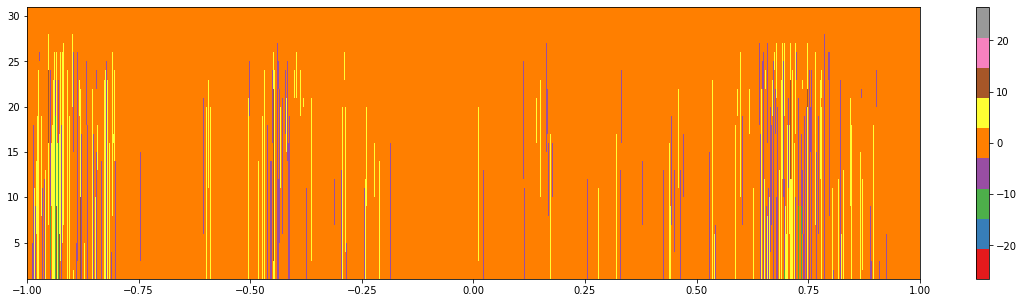

In [47]:
plt.figure(figsize=(20, 5))
plt.imshow(cwtmatr[:len(cwtmatr)], extent=[-1, 1, 1, 31], cmap='Set1', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()
plt.savefig("wavelet_1.png")
plt.show()

## しらせデータと結合

In [48]:
for i in range(0, 30):
    shirase_spc[i+1] = cwtmatr[i, :]

## しぶきのラベリング

In [ ]:
spray_all = np.array(shirase_spc['SPC_flux[mm]'])
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i != 0 else 0 for i in spray_all]
shirase_spc['label'] = spc_label

# 不要データの削除

In [58]:
shirase_spc.columns

Index([        'ピッチ (度)',    'ピッチレート (度/秒)',     'ヨーレート (度/秒)',
               'ロール (度)',    'ロールレート (度/秒)',      '相対風速 (m/s)',
        '相対風速 (m/s)_cos',  '相対風速 (m/s)_sin',          '経度 (度)',
                '緯度 (度)',        '艦首方位 (度)',           '計測ノッチ',
               '速力 (kt)',          '速力指令　右',          '速力指令　左',
               '速度 (kt)',    'SPC_flux[mm]',             'mwp',
                   't2m',             'sst',             'mwd',
                    'tp',             'swh',             'u10',
                   'v10',           'label', 'relative_wind_y',
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8,                 9,
                      10,                11,                12,
                      13,                14,                15,
                      16,                17,                18,
                      19,               

In [59]:
del_list = ['ピッチレート (度/秒)', 'ヨーレート (度/秒)', 'ロール (度)', 'ロールレート (度/秒)','経度 (度)',
           '緯度 (度)','計測ノッチ', '速力 (kt)', '速力指令　右', '速力指令　左',]

In [60]:
for i in del_list:
    del shirase_spc[i]

In [61]:
shirase_spc = shirase_spc.rename(columns={'速度 (kt)' : 'Speed[knot]', '艦首方位 (度)':'Course[deg]'})

In [64]:
x = shirase_spc['相対風速 (m/s)_cos']
y = shirase_spc['相対風速 (m/s)_sin']
shirase_spc['Relative_wind_direction[deg]'] = np.rad2deg(np.arctan(y/x))

In [ ]:
# def polar2xy(df, vec):
#     #極座標パラメーターを直交座標パラメーターに変換
#     speed = vec[0]
#     degree = vec[1]
#     v_x = df[speed]*np.cos(df[degree]/180*np.pi) #南北or 船首
#     v_y = df[speed]*np.sin(df[degree]/180*np.pi) #東西or 船側
#     df["{}_x".format(speed)] = v_x
#     df["{}_y".format(speed)] = v_y
#     return df

In [ ]:
# vec_list = [
# ['Speed[knot]', 'Course[deg]'],
# ['Relative wind speed[m/s]'     , 'Relative wind direction[deg]']]

In [ ]:
# df["Relative wind direction[deg]"] = np.rad2deg(np.arccos(df['相対風速 (m/s)_cos']/df['相対風速 (m/s)']))

In [66]:
shirase_spc = shirase_spc.rename(columns={'相対風速 (m/s)':'Relative wind speed[m/s]'})

In [ ]:
# for vec in vec_list:
#     if vec[0] in df.columns:
#         df = polar2xy(df, vec)

In [ ]:
# def resample(df,freq="T", sep_tp=0.01, sep_swh=0.5):
#     df = df.drop_duplicates().dropna().sort_index().resample("S").nearest(300)

#     tmp = df.resample(freq).mean()
#     len_raw = len(df)//60
#     # 雨を除外
#     tmp = tmp.loc[tmp['tp'] <= sep_tp*0.001, :]
# #     # 風を除外
#     #tmp = tmp.loc[tmp['Relative wind speed[m/s]_y'] > 0, :]
#     tmp = tmp.loc[tmp['swh'] > sep_swh, :]
#     print("avalable data ratio:{} %".format(len(tmp)/len_raw*100), len(tmp))
#     return tmp

In [ ]:
# def rose(tmp, value, direction, title, name, mode="wind"):
#     import fushiming.graph.polar as polar
#     ws = tmp[value]
#     dr = tmp[direction]
#     if mode == "wave":
#         dr = dr + 180
# #     dr[dr < 0] = dr+360
# #     dr[dr>360]=dr-360
#     wr = polar.windrose(dr, ws)
#     wr.label_to_degree()
#     number_of_sections = 16
#     wr.draw_bar(bins=6, title=title, name = name, mode=mode, nsector=number_of_sections*10,
#                        fontsize=15)

In [ ]:
# df_resampled["Relative wind direction[deg]"] = 360 - (df_resampled["Relative wind direction[deg]"] - 90)

In [ ]:
# import matplotlib.pyplot as plt
# from windrose import WindroseAxes
# import matplotlib.cm as cm

# fontsize = 15
# ax = WindroseAxes.from_ax()
# ax.bar(df_resampled["Relative wind direction[deg]"], df_resampled['Relative wind speed[m/s]'],
#            normed=True, opening=0.8, edgecolor='white', nsector=160, bins=np.arange(0, 25, 5))
# ax.set_legend(fontsize=fontsize)
# ax.tick_params(labelsize = fontsize)
# ax.set_thetagrids(angles=ax.theta_angles, labels=[90, 45, 0, 315, 270, 225, 180, 135])
# #ax.legend(fontsize=fontsize,bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
# plt.title("Relative wind rose", fontsize=fontsize)
# rose_file = "./dataset/cruise/jare60/windrose_shirase.png"
# plt.savefig(rose_file)
# plt.show()

## 出会い周期

航行する船舶が体感で感じる波の周期のこと．
海洋波の周期（era5のmwpに相当，ただしこれは一時間おき），船舶の速度，相対波向（era5のmwdの単位はdegreeのため，そのまま代入すれば良い）から求められる．

### 相対波向
船舶の進路方向から見た波向．

- 相対波向：\$ \chi[deg] \$
- 船舶方向：\$ D[deg]\$
- 波向：\$ W[deg]\$

$$
\chi = D - W
$$

- 海洋波の周期: \$ T_{w} \$
- 船舶の速度：\$ V \$
- 出会い周期：\$T_{e}\$

$$
T_{e} = \frac{\frac{gT_{w}^2}{2\pi}}{\frac{gT_{w}}{2\pi} + Vcos\chi} 
$$


In [76]:
# mwdが負の地点の処理
shirase_spc['mwd'] = shirase_spc['mwd'].where(shirase_spc['mwd'] >= 0, 0.0)

In [84]:
# 相対波向：船舶正面から波が向かってくる場合を90度
shirase_spc['Relative wave direction[deg]'] = shirase_spc['Course[deg]'] - shirase_spc['mwd'] + 90

In [92]:
df_resampled = shirase_spc
df_resampled['Relative wave direction[deg]'] = df_resampled['Relative wave direction[deg]'].where(
                                                                    df_resampled['Relative wave direction[deg]'] >= 0,
                                                                    df_resampled['Relative wave direction[deg]'] + 360)
df_resampled['Relative wave direction[deg]'] = df_resampled['Relative wave direction[deg]'].where(
                                                                    df_resampled['Relative wave direction[deg]'] < 360,
                                                                    df_resampled['Relative wave direction[deg]'] - 360)

In [94]:
df_resampled['Speed[m/s]'] = df_resampled['Speed[knot]'] * 0.5144

In [95]:
g = 9.8
df_resampled['encounter cycle'] = (g * df_resampled['mwp'] ** 2 / (2 * np.pi)) / ((g * df_resampled['mwp'] / (2 * np.pi)) + df_resampled['Speed[m/s]'] * np.cos(np.deg2rad(df_resampled['Relative wave direction[deg]'])))

In [109]:
for_hist_list = ['encounter cycle', 'ピッチ (度)', 'Speed[knot]', 'relative_wind_y', 'swh']
for_hist_name = ['Average encounter\nperiod[s]', 'Pitch amplitude[deg]', 'Ship speed[knot]',
                          'Wind speed\nfrom bow direction[m/s]', 'Significant wave\nheight[m]']

In [110]:
df_resampled.columns

Index([                     'ピッチ (度)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
                                'swh',                          'u10',
                                'v10',                        'label',
                    'relative_wind_y',                              1,
                                    2,                              3,
                                    4,                              5,
                                    6,                              7,
                                    8,                              9,
                                   10,                             11,
      

In [114]:
df_resampled = df_resampled[df_resampled['encounter cycle'] >= 0]
#df_resampled = df_resampled[df_resampled['encounter cycle'] <= 20]

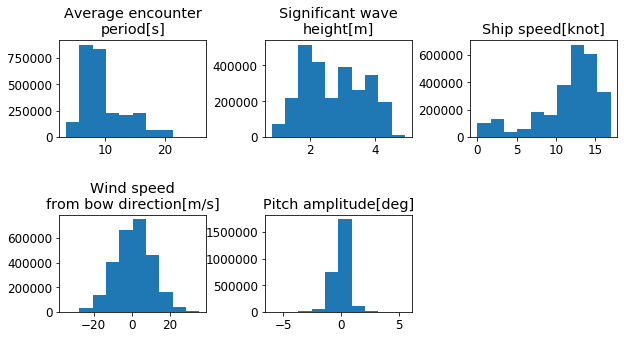

In [115]:
from matplotlib import rcParams
#import japanize_matplotlib


# 1次元histを描画
def draw_1dhist(df, cols, name, file_name):
    plt.subplots_adjust(wspace=1.1, hspace=0.8)
    for i, col in enumerate(cols):
        plt.subplot(2, 3, i+1)
        plt.hist(df[col])
        plt.title(name[i])
    plt.savefig(file_name)
    plt.show()
    
def draw_1dhist_test(df, cols, name, file_name):
    fig, ax = plt.subplots(2, 3, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    for i, col in enumerate(cols):
        ax[i%2, i%3].hist(df[col])
        ax[i%2, i%3].set_title(name[i])
    ax[1, 2].tick_params(labelbottom=False,
                                                  bottom=False,
                                                 labelleft=False,
                                                 left=False)
    ax[1, 2].spines["right"].set_color("none")  # 右消し
    ax[1, 2].spines["left"].set_color("none")   # 左消し
    ax[1, 2].spines["top"].set_color("none")    # 上消し
    ax[1, 2].spines["bottom"].set_color("none") # 下消し
    plt.savefig(file_name)
    plt.show()
    
hist_path = "./1dhist_shirase_fixed.png"
draw_1dhist_test(df_resampled, for_hist_list, for_hist_name, hist_path)

In [124]:
spc_data = df_resampled['SPC_flux[mm]']
for_2dhist_plot = [ 'Significant wave\nheight[m]', 'Ship speed[knot]', 'Pitch amplitude[deg]', 
                     'Wind direction\nrelative to ship cource[deg]', 'Wind speed\nrelative to ship speed[m/s]', 'Wind speed\nfrom bow direction[m/s]',
                          'Average encounter period[s]']
extracted_data = ['swh', 'Speed[knot]', 'ピッチ (度)', 'Relative_wind_direction[deg]',
                           'Relative wind speed[m/s]', 'relative_wind_y', 'encounter cycle']

<Figure size 432x288 with 0 Axes>

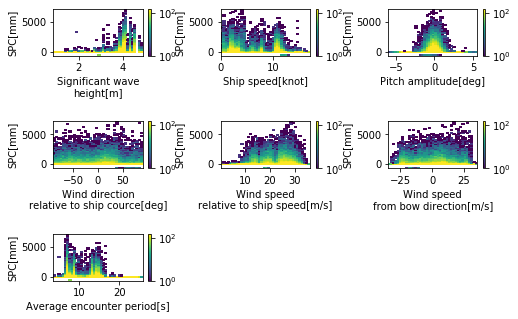

In [127]:
from matplotlib import rcParams,colors

num=2
plt.subplots_adjust(wspace=0.2, hspace=13)
rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')

for i, col in enumerate(extracted_data):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=1.4)
    plt.hist2d(df_resampled[col], spc_data,
                   bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
    plt.xlabel(for_2dhist_plot[i])
    plt.ylabel('SPC[mm]')
    plt.colorbar()
    #plt.ylim([0, 50])
plt.savefig("./2dhist_shirase.png")
plt.show()

# ERA5からの海水飛沫予測

「しらせ」の船速・船向とERA5のデータセットを組み合わせることにより，飛沫発生時の海象の傾向を見ることを目的とする．また，ERA5データセットの気象・海象データから解析データ内の飛沫発生を予測できないかを探ることとする．

## 船長波長比と飛沫量の関係
伏見さんの修論中では，船体波長比と飛沫量との間に相関が見られる．この船体波長比は以下の式で計算できる．

- 海洋波の周期(ERA5より取得): \$ T_{w} \$
- 海洋波の波長: \$ \lambda \$

$$
\lambda = \frac{gT_{w}^2}{2\pi}
$$

- 船長: \$ L \$
- 船体波長比: \$ M \$

$$
M = \frac{\lambda}{L}
$$

In [129]:
# 船体波長比を算出(しらせ2代目)
L = 138.0
df_resampled['wave_length'] = g * df_resampled['mwp']**2 / (2 * np.pi)
df_resampled['ratio'] = df_resampled['wave_length'] / L

/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_resampled.to_pickle("./data")

# しらせでは相対風速を測定しているので以下はいらない

## ERA5の風速・風向データを用いた飛沫量予測
具体的には，ERA5の10u, 10vを用いる．

- 10u: 地上10mにおける，風速の東西方向成分．東に向かって吹く場合を正．
- 10v: 地上10mにおける，風速の南北方向成分．北に向かって吹く場合を正．

<img src="./dataset/cruise/jare60/how_to_calc_wind_direction.png" width="300" height="300">

In [ ]:
# # 絶対風向値を算出
# df_resampled['era5_abs_wind_direction'] = np.rad2deg(np.arctan(df_resampled['v10'] / df_resampled['u10']))
# df_resampled['era5_abs_wind_direction'] = df_resampled['era5_abs_wind_direction'].where(
#                                                                     df_resampled['era5_abs_wind_direction'] >= 0,
#                                                                     df_resampled['era5_abs_wind_direction'] + 360)

In [ ]:
# # 船舶進路から見た相対風向を算出
# df_resampled['era5_rel_wind_direction'] = df_resampled['Course[deg]'] - df_resampled['era5_abs_wind_direction']

In [ ]:
# # 修正
# df_resampled['era5_rel_wind_direction'] = df_resampled['era5_rel_wind_direction'].where(
#                                                                     df_resampled['era5_rel_wind_direction'] >= 0,
#                                                                     df_resampled['era5_rel_wind_direction'] + 360)

In [ ]:
# # 船首方向からの風速を追加
# df_resampled['era5_wind_speed'] = np.sqrt(df_resampled['u10'] ** 2 + df_resampled['v10'] ** 2)
# df_resampled['era5_wind_speed_from_the_bow'] = -1 * np.cos(df_resampled['era5_rel_wind_direction']) * \
#                                                                                     df_resampled['era5_wind_speed']

### ERA5の海象・気象予報データと飛沫量の2次元ヒストグラム
主に，以下の海象・気象予報データを用いる．

- 出会い周期
- 相対波向
- 船長波長比
- 有義波向
- 相対風向
- 船首方向からの風速

In [ ]:
# extracted_data_era5 = ['encounter cycle', 'Relative wave direction[deg]', 'ratio', 'swh', 'era5_rel_wind_direction', 
#                              'era5_wind_speed_from_the_bow']
# name_era5 = ['Average encounter period[s]', 'Wave direction\nrelative to ship cource[deg]', 
#                     'ratio between the ship length\nand the wave length', 'Significant wave\nheight[m]',
#                     'Wind direction\nrelative to ship cource[deg]', 'Wind speed\nfrom bow direction[m/s]']

In [ ]:
# from matplotlib import rcParams,colors

# num=2
# rcParams.update({'font.size': 10})
# fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')

# for i, col in enumerate(extracted_data_era5):
#     plt.subplot(3, 2, i+1)
#     plt.subplots_adjust(wspace=0.2, hspace=1.4)
#     plt.hist2d(df_resampled[col], spc_data,
#                    bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
#     plt.xlabel(name_era5[i])
#     plt.ylabel('SPC[mm]')
#     plt.colorbar()
#     plt.ylim([0, 50])
# plt.savefig("./dataset/cruise/jare60/2dhist_era5.png")
# plt.show()

# スペクトログラム

In [ ]:
pitch_from_df = np.array(df_resampled['ピッチ (度)'])

In [ ]:
def resample(df,freq="T", sep_tp=0.01, sep_swh=0.5):
    df = df.drop_duplicates().dropna().sort_index().resample("S").nearest(300)

    tmp = df.resample(freq).mean()
    len_raw = len(df)//60
    # 雨を除外
    tmp = tmp.loc[tmp['tp'] <= sep_tp*0.001, :]
#     # 風を除外
    #tmp = tmp.loc[tmp['Relative wind speed[m/s]_y'] > 0, :]
    tmp = tmp.loc[tmp['swh'] > sep_swh, :]
    print("avalable data ratio:{} %".format(len(tmp)/len_raw*100), len(tmp))
    return tmp

In [ ]:
df_resampled['swh'].describe()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.array(pitch_from_df))

In [ ]:
#S, n_fft = _spectrogram(y=pitch_from_df, n_fft=64, hop_length=1, power=2)
S = np.abs(librosa.core.stft(pitch_from_df, n_fft=64, hop_length=1, window='hann'))

In [ ]:
S.shape

In [ ]:
import librosa.display

In [ ]:
plt.figure(figsize=(15,5))
#librosa.display.specshow(librosa.amplitude_to_db(S[:, :10000], ref=np.max), sr=1, x_axis='time')
librosa.display.specshow(librosa.amplitude_to_db(S[:, :10000]), sr=1, x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
S_db = librosa.power_to_db(S, ref=np.max)
S_db

In [ ]:
S_db = librosa.power_to_db(S, ref=np.max)
plt.imshow(S_db)
#librosa.display.specshow(S_db, x_axis='time', y_axis='freq')
plt.colorbar()

# 飛沫予測

## 船体運動のピッチを処理
船体運動のピッチを

In [ ]:
df_resampled.columns

In [ ]:
df_resampled.corr().loc['SPC_flux[mm]', :]

In [ ]:
df_copy = df_resampled

In [ ]:
# ピッチ部分を抽出(1秒ごと)
pitch_from_df = df_copy['ピッチ (度)']
# arrayに変換
pitch_from_df_array = np.array(pitch_from_df)

In [ ]:
from tqdm import tqdm

def calc_fft(data, delta=1, n=32):
    """
    区間サンプル数(n)の窓関数で切り出した波形に対しFFTを実行．
    
    data: 対象データ
    delta: ずらす時間
    n: 窓関数のサンプル数
    """
    output = []
    # ハミング窓を生成
    hamming_window = np.hamming(n)
    # 時間軸をずらしながら窓関数を掛け，FFT
    for i in tqdm(range(len(data))):
        section = data[i * delta : i * delta + n]
        if len(section) < n:
            section = np.pad(section, [0, n - len(section)], 'constant')
        extracted_data = section * hamming_window
        fft_extracted_data = np.abs(np.fft.fft(extracted_data))[:int(n/2)+1]
        fft_extracted_data = fft_extracted_data / n * 2
        fft_extracted_data[0] = fft_extracted_data[0] / 2
        output.append(fft_extracted_data)
        #output.append([0.01 if i == 0 else i for i in fft_extracted_data])

    return output

In [ ]:
pitch_fft = calc_fft(pitch_from_df_array)
pitch_fft = np.array(pitch_fft)

In [ ]:
pd_pitch_fft = pd.DataFrame(pitch_fft)

In [ ]:
!pwd

In [ ]:
import pickle
with open('/Users/nakamurataiki/Dataset/pitch_fft.pickle', 'wb') as f:
    pickle.dump(pitch_fft, f)

In [ ]:
df_copy['idx'] = np.arange(0, df_copy.shape[0])

In [ ]:
df_copy.columns

In [ ]:
pd_pitch_fft['idx'] = np.arange(0, pd_pitch_fft.shape[0])

In [ ]:
df_copy_concated = pd.merge(df_copy, pd_pitch_fft, on='idx')

In [ ]:
import pickle
# with open('./dataset/cruise/jare60/df_copy_concated.pickle', 'wb') as f:
#     pickle.dump(df_copy_concated, f)
with open('/Users/nakamurataiki/Dataset/df_copy_concated.pickle', 'wb') as f:
    pickle.dump(df_copy_concated, f)

In [ ]:
df_copy_concated = pd.read_pickle('~/Dataset/df_copy_concated.pickle')
df_copy = df_copy_concated

In [ ]:
df_copy.shape

#### 飛沫データのラベリング

In [ ]:
# 降雨量の閾値
sep_tp = 0.01
# 飛沫量の閾値
sep_spc = 1000
# 波の閾値
sep_swh = 0.5

df_copy = df_copy.loc[df_copy['tp'] <= sep_tp*0.001, :]
#df_copy = df_copy.loc[df_copy['SPC_flux[mm]'] <= sep_spc, :]
#df_copy = df_copy.loc[df_copy['swh'] > sep_swh, :]
df_copy = df_copy.loc[df_copy['swh'] >= 0, :]
spray_all = df_copy['SPC_flux[mm]']

spray_all = np.array(spray_all)
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i != 0 else 0 for i in spray_all]
df_copy['spc_label'] = spc_label

#### 飛沫データの割合

In [ ]:
print(sum(spc_label) / len(spc_label) * 100)

In [ ]:
print(sum(spc_label), len(spc_label))

In [ ]:
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib import rcParams,colors

figsize = (10, 8)
cases = [i for i in range(17)]
cols = 3
rows = len(cases) // cols + 1
# サンプリング周期[sec]
dt = 1.0
# 周波数軸
n = 32
fq = np.linspace(0, 1.0/dt, n)[:int(n/2)+1]
#fq = fftpack.fftfreq(n=wave.size, d=1/fs)[:int(n/2)]
print(fq)

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(cases))
for ax, case in zip(axs, cases):
    ax.set_title("{}[s]".format(1/fq[case]))
    ax.hist2d(df_copy[case], df_copy['SPC_flux[mm]'], bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
fig1.savefig("/Users/nakamurataiki/Desktop/fft_results_hist2d.png")
    #ax.plot(x, y, 'o', ls='-', ms=4, markevery=case)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(pitch_from_df_array)
plt.title("")
plt.grid(True)

## ロジスティック回帰

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

In [ ]:
with open('/Users/nakamurataiki/Dataset/df_copy_pre_trained.pickle', 'wb') as f:
    pickle.dump(df_copy, f)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

def devide_dataset(data, label, test_size=0.3, smote_ratio={1: 10000}, is_smote=True):
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=test_size)
    if is_smote:
        X_train_resampled, y_train_resampled = SMOTEENN(ratio=smote_ratio,
                                                                                random_state=0,
                                                                                smote=SMOTE(n_jobs=3, random_state=0)
                                                                               ).fit_sample(X_train, y_train)
        print("SMOTE前: 0の数 = {} 1の数 = {}".format(len(y_train), sum(y_train)))
        print("SMOTE後: 0の数 = {} 1の数 = {}".format(len(y_train_resampled), sum(y_train_resampled)))
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        print("データバランス: 0の数 = {} 1の数 = {}".format(len(y_train), sum(y_train)))
    
    return X_train_resampled, X_test, y_train_resampled, y_test
    
    
selected_column = ['swh', 0, 1, 2, 3, 4, 5, 'Relative wind speed[m/s]']
train = df_copy.loc[:, selected_column]
test = df_copy['spc_label']

X_train_resampled, X_test, y_train_resampled, y_test = devide_dataset(train, test, 0.3, {1: 10}, False)

# 訓練
lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)
y_test_predicted = lr.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted)
print("accuracy: {}".format(accuracy_score(y_test, y_test_predicted)))
print("precision: {}".format(precision_score(y_test, y_test_predicted)))
print("recall: {}".format(recall_score(y_test, y_test_predicted)))
print("f1_score: {}".format(f1_score(y_test, y_test_predicted)))
print(cm)

## 機械学習
### ロジスティック回帰
#### 結果色々

||デフォルト|SMOTEEN|
|:--|--:|:--:|
|飛沫なし|765373|1353121|
|飛沫あり|32542|709112|
|accuracy|0.957285880652891|0.1787798230584907|
|precision|0.000000000000000|0.04902563016310104|
|recall|      0.000000000000000|0.9998560011519908|
|f1-score|-|0.0934682600311628|

#### 混同行列
[[314007      0]
 [ 14011      0]]
 
 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)
        
    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)
        
    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

reduction_data = []
#reduction_data = ['swh', '速度 (kt)', '相対風速 (m/s)', 0, 1]
#reduction_data = ['Relative wind speed[m/s]', 'swh']
reduction_data.extend([i for i in range(0, 3)])
for_reduction = df_copy.loc[:, reduction_data]
label = df_copy.iloc[:, -1]
print(for_reduction.shape, label.shape)
plot_reduced_graph(for_reduction, label, 'pca_relativewind_swh', model='pca', random_sampling=False)